### *shree ganeshaya namaha*

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Load the dataset
import pandas as pd

# Load UFO data
df = pd.read_csv('/content/drive/MyDrive/UFO/nuforc_india.csv', encoding='ISO-8859-1')
df.head()


,Link,Occurred,City,State,Country,Shape,Summary,Reported,Media,Explanation
0,Open,04-09-2025 18:01,Howrah,West Bengal,India,Circle,Seen from the window of a flat on the fourth f...,04-09-2025,NaN,NaN
1,Open,04-05-2025 22:15,Dindigul,Tamil Nadu,India,Circle,Strange Circle of Lights in Night Sky,04-05-2025,Y,Searchlight
2,Open,03/18/2025 20:06,Haridwar,Uttarakhand,India,Triangle,"Saw a silent, transparent/black triangular cra...",03/18/2025,NaN,NaN
3,Open,03/18/2025 05:00,Ranchi,Jharkhand,India,Disk,I was waiting for my father when i saw a disk ...,03/18/2025,NaN,NaN
4,Open,03-11-2025 19:17,Gurugram,Haryana,India,Circle,Glowing Orb,03-11-2025,Y,ISS


In [ ]:
# Preprocessing the description text
import re

def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

df['cleaned_description'] = df['Summary'].apply(clean_text)
df[['Summary', 'cleaned_description']].head()

,Summary,cleaned_description
0,Seen from the window of a flat on the fourth f...,seen from the window of a flat on the fourth f...
1,Strange Circle of Lights in Night Sky,strange circle of lights in night sky
2,"Saw a silent, transparent/black triangular cra...",saw a silent transparentblack triangular craft...
3,I was waiting for my father when i saw a disk ...,i was waiting for my father when i saw a disk ...
4,Glowing Orb,glowing orb


## VADER

In [ ]:
# VADER Sentiment Analysis
# Valence Aware Dictionary for Sentiment Reasoning
!pip install -q vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

vader_analyzer = SentimentIntensityAnalyzer()
df['vader_score'] = df['cleaned_description'].apply(lambda x: vader_analyzer.polarity_scores(x)['compound'])

def vader_label(score):
    if score >= 0.05:
        return 'positive'
    elif score <= -0.05:
        return 'negative'
    else:
        return 'neutral'

df['vader_sentiment'] = df['vader_score'].apply(vader_label)
df[['cleaned_description', 'vader_score', 'vader_sentiment']].head()

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 3.3 MB/s eta 0:00:00


,cleaned_description,vader_score,vader_sentiment
0,seen from the window of a flat on the fourth f...,0.0000,neutral
1,strange circle of lights in night sky,-0.2023,negative
2,saw a silent transparentblack triangular craft...,0.0000,neutral
3,i was waiting for my father when i saw a disk ...,0.0772,positive
4,glowing orb,0.0000,neutral


<ipython-input-6-be5c4ebe2a18>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='vader_sentiment', palette='Set2', order=['positive', 'neutral', 'negative'])


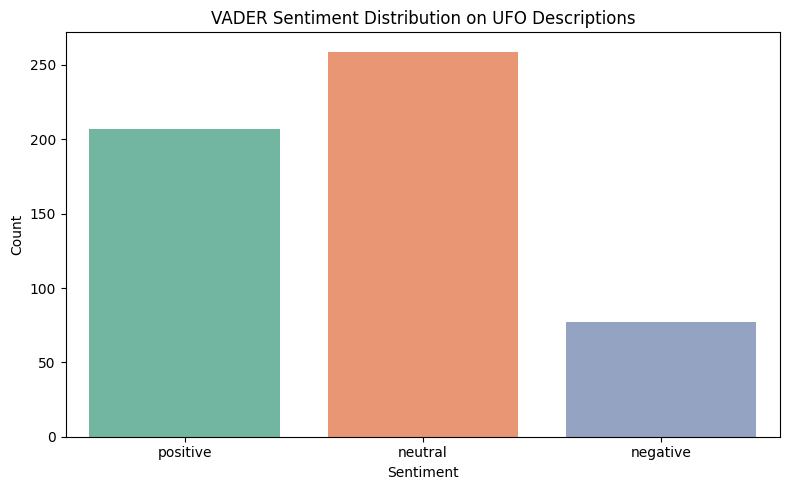

In [ ]:
# Visualize VADER sentiment distribution
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='vader_sentiment', palette='Set2', order=['positive', 'neutral', 'negative'])
plt.title('VADER Sentiment Distribution on UFO Descriptions')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

## DistilBERT

### DistilBERT on Whole Dataset

In [ ]:
# running on while dataset
# lighter version of BERT (Bidirectional Encoder Representations from Transformers
# Run on a smaller subset for speed
df['bert_result'] = df['cleaned_description'].apply(lambda x: sentiment_pipeline(x)[0])
df['bert_label'] = df['bert_result'].apply(lambda x: x['label'])
df['bert_score'] = df['bert_result'].apply(lambda x: x['score'])

df[['cleaned_description', 'bert_label', 'bert_score']].head()

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


,cleaned_description,bert_label,bert_score
0,seen from the window of a flat on the fourth f...,NEGATIVE,0.998033
1,strange circle of lights in night sky,POSITIVE,0.992163
2,saw a silent transparentblack triangular craft...,NEGATIVE,0.999307
3,i was waiting for my father when i saw a disk ...,NEGATIVE,0.999612
4,glowing orb,POSITIVE,0.999592


<ipython-input-53-110ac75b60be>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='bert_label', palette='Set2')


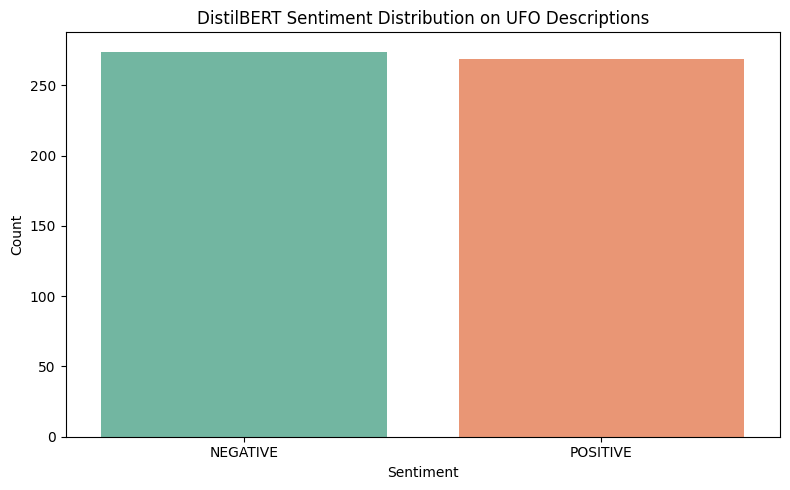

In [ ]:
# Visualize BERT sentiment distribution
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='bert_label', palette='Set2')
plt.title('DistilBERT Sentiment Distribution on UFO Descriptions')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

## Sentiment vs. Time


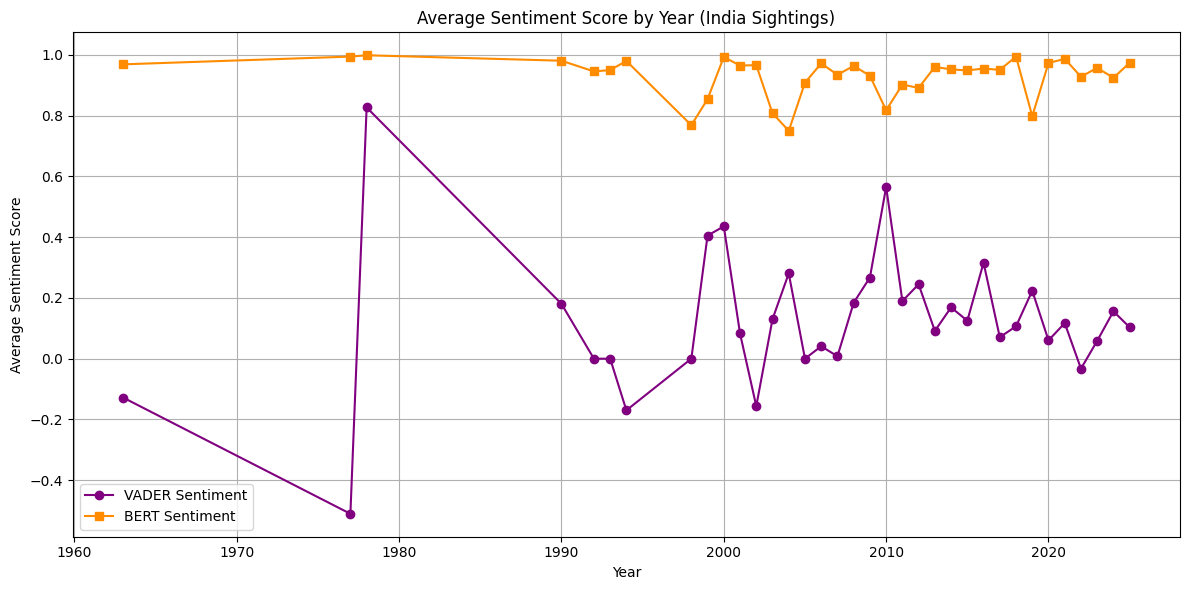

In [ ]:
# Extract year (in case it hasn't been done yet)
df['datetime'] = pd.to_datetime(df['Occurred'], errors='coerce')
df['year'] = df['datetime'].dt.year

# Group by year for both sentiment types
yearly_vader = df.groupby('year')['vader_score'].mean()
yearly_bert = df.groupby('year')['bert_score'].mean()

# Plot both
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(yearly_vader.index, yearly_vader, marker='o', label='VADER Sentiment', color='purple')
plt.plot(yearly_bert.index, yearly_bert, marker='s', label='BERT Sentiment', color='darkorange')

plt.title('Average Sentiment Score by Year (India Sightings)')
plt.xlabel('Year')
plt.ylabel('Average Sentiment Score')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


## Sentiment vs. Location

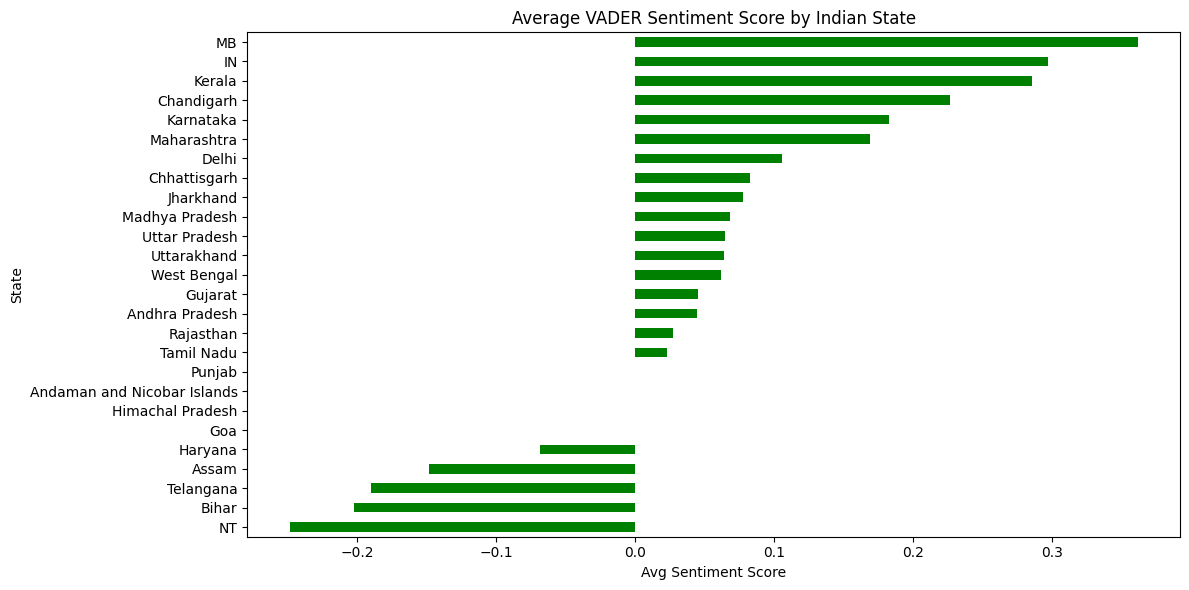

In [ ]:
# Sentiment by US State (for example)
state_sentiment = df.groupby('State')['vader_score'].mean().sort_values()

plt.figure(figsize=(12, 6))
state_sentiment.plot(kind='barh', color='green')
plt.title('Average VADER Sentiment Score by Indian State')
plt.xlabel('Avg Sentiment Score')
plt.ylabel('State')
plt.tight_layout()
plt.show()


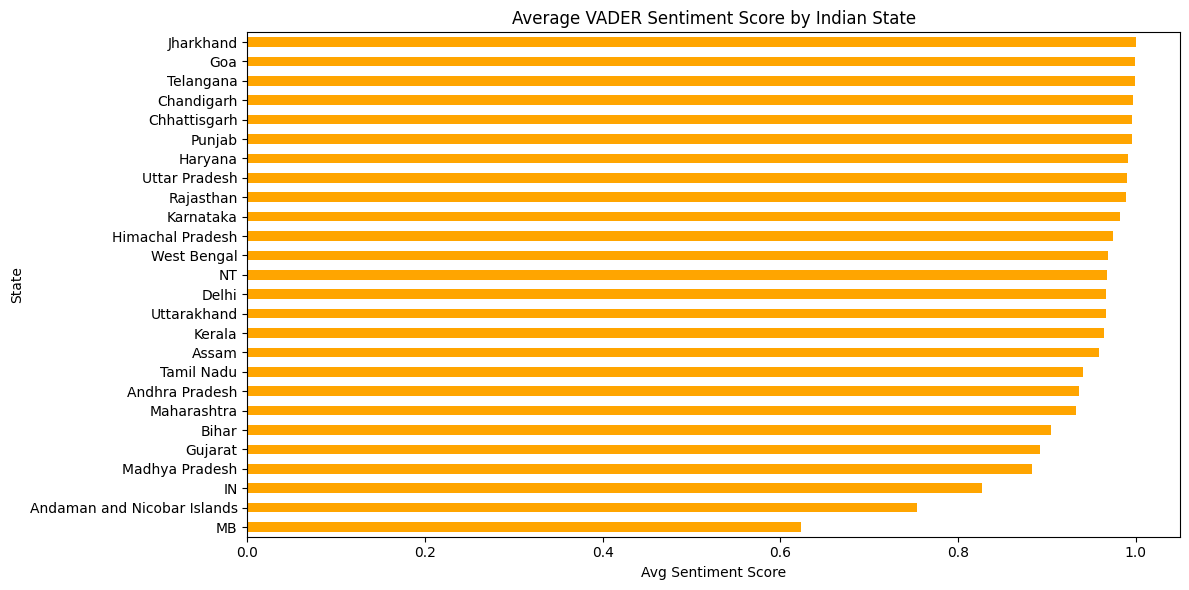

In [ ]:
# Sentiment by US State (for example)
state_sentiment = df.groupby('State')['bert_score'].mean().sort_values()

plt.figure(figsize=(12, 6))
state_sentiment.plot(kind='barh', color='orange')
plt.title('Average VADER Sentiment Score by Indian State')
plt.xlabel('Avg Sentiment Score')
plt.ylabel('State')
plt.tight_layout()
plt.show()


# Advanced Techniques

## 1. Finetuned Transformer Models for Emotion Classification

Model: j-hartmann/emotion-english-distilroberta-base
Output: Multi-class emotion tags like: joy, anger, fear, surprise, disgust, sadness, neutral

In [ ]:
# Emotion Classification with DistilRoBERTa (j-hartmann/emotion)
!pip install -q transformers
from transformers import pipeline
import matplotlib.pyplot as plt
import seaborn as sns

# Load pipeline
emotion_classifier = pipeline("text-classification", model="j-hartmann/emotion-english-distilroberta-base", return_all_scores=False)

# Apply to sampled data
# sampled_df = df.sample(n=1000, random_state=42).copy()
df['hartmann_emotion'] = df['cleaned_description'].apply(lambda x: emotion_classifier(x)[0]['label'])


Device set to use cuda:0
/usr/local/lib/python3.11/dist-packages/transformers/pipelines/text_classification.py:106: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


<ipython-input-20-f47b9d73209c>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='hartmann_emotion', order=df['hartmann_emotion'].value_counts().index, palette='Set2')


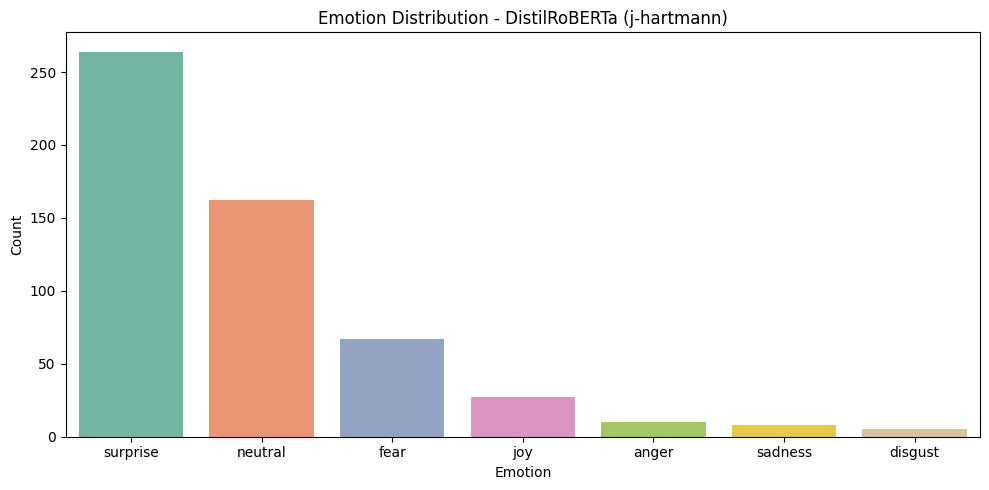

In [ ]:
# Visualization
plt.figure(figsize=(10, 5))
sns.countplot(data=df, x='hartmann_emotion', order=df['hartmann_emotion'].value_counts().index, palette='Set2')
plt.title('Emotion Distribution - DistilRoBERTa (j-hartmann)')
plt.xlabel('Emotion')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

## 2. Multi-label Sentiment (Positive + Fear + Surprise)
Model: cardiffnlp/twitter-roberta-base-emotion
Trained on tweets but works well on short descriptions.

In [ ]:
# Emotion Classification with CardiffNLP Twitter-RoBERTa
!pip install -q transformers torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import numpy as np

model_name = "cardiffnlp/twitter-roberta-base-emotion"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

labels = ['anger', 'joy', 'optimism', 'sadness']

def classify_emotion(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True)
    with torch.no_grad():
        outputs = model(**inputs)
        scores = torch.nn.functional.softmax(outputs.logits, dim=1)
        return labels[scores.argmax().item()]

df['cardiff_emotion'] = df['cleaned_description'].apply(classify_emotion)



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 115.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 99.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 48.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 62.5 MB/s eta 0:00:00


config.json:   0%|          | 0.00/768 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

<ipython-input-23-adbf2d2fe528>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='cardiff_emotion', order=df['cardiff_emotion'].value_counts().index, palette='Set1')


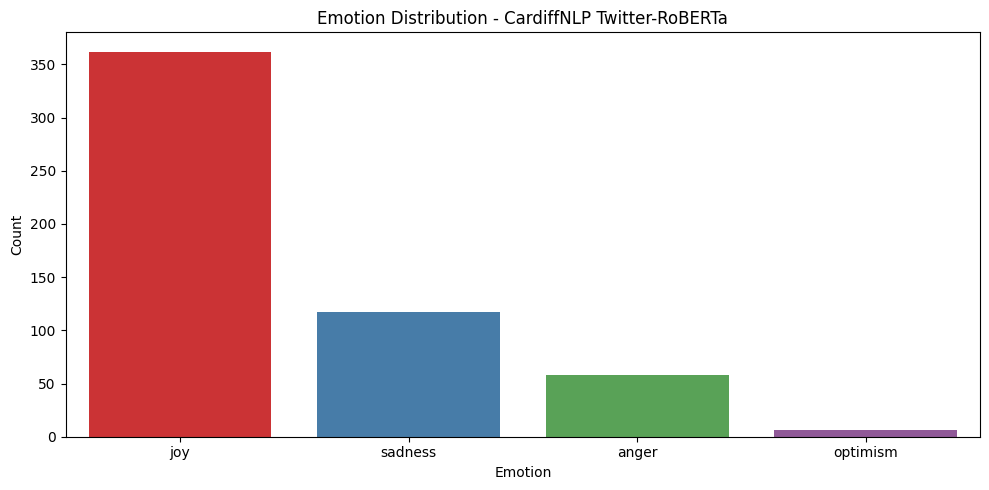

In [ ]:
# Visualization
plt.figure(figsize=(10, 5))
sns.countplot(data=df, x='cardiff_emotion', order=df['cardiff_emotion'].value_counts().index, palette='Set1')
plt.title('Emotion Distribution - CardiffNLP Twitter-RoBERTa')
plt.xlabel('Emotion')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

## 3. Zero-shot Classification for Sentiment/Emotion Themes
If you want custom labels (e.g., fear, confusion, amazement), you can use zero-shot-classification:

In [ ]:
# Zero-shot Classification with Custom Emotion Labels
zero_shot = pipeline("zero-shot-classification")
custom_labels = ["fear", "amazement", "confusion", "excitement", "anger", "indifference"]

df['zero_shot_emotion'] = df['cleaned_description'].apply(
    lambda x: zero_shot(x, candidate_labels=custom_labels)['labels'][0]
)


No model was supplied, defaulted to facebook/bart-large-mnli and revision d7645e1 (https://huggingface.co/facebook/bart-large-mnli).
Using a pipeline without specifying a model name and revision in production is not recommended.


config.json:   0%|          | 0.00/1.15k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Device set to use cuda:0


<ipython-input-25-d66d798d01d3>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='zero_shot_emotion', order=df['zero_shot_emotion'].value_counts().index, palette='coolwarm')


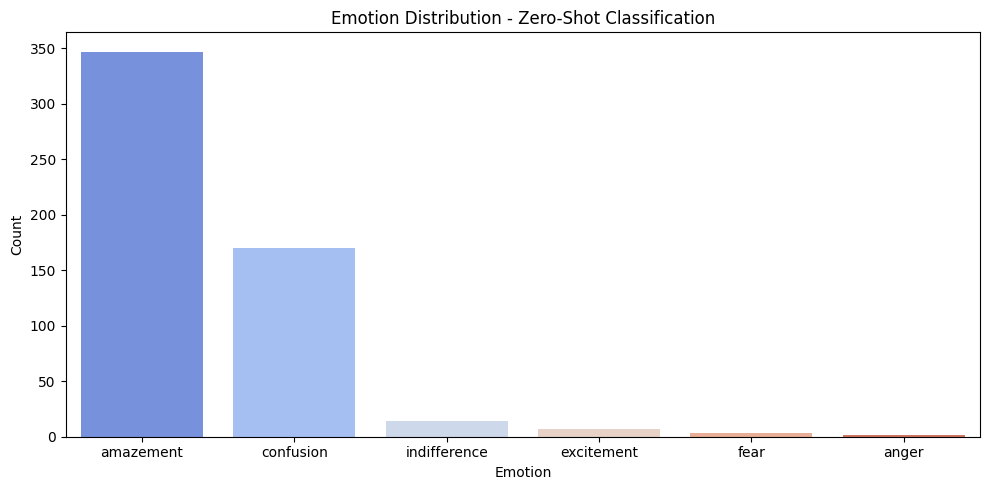

In [ ]:
# Visualization
plt.figure(figsize=(10, 5))
sns.countplot(data=df, x='zero_shot_emotion', order=df['zero_shot_emotion'].value_counts().index, palette='coolwarm')
plt.title('Emotion Distribution - Zero-Shot Classification')
plt.xlabel('Emotion')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

## 4. Sentence Embeddings + Clustering (Unsupervised Sentiment)
USentence-BERT + KMeans — you may discover natural groupings like:

“blinking lights above house”

“loud metallic hum before craft”

“lost time and missing hours”

Not sentiment per se, but powerful for latent emotional themes.

In [ ]:
# Sentence-BERT + Clustering
!pip install -q sentence-transformers scikit-learn
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans

# Embed descriptions
model = SentenceTransformer('all-MiniLM-L6-v2')
embeddings = model.encode(df['cleaned_description'].tolist(), show_progress_bar=True)

# KMeans Clustering
kmeans = KMeans(n_clusters=6, random_state=42)
df['cluster'] = kmeans.fit_predict(embeddings)

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/17 [00:00<?, ?it/s]

<ipython-input-27-e8cd64984077>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='cluster', palette='Accent')


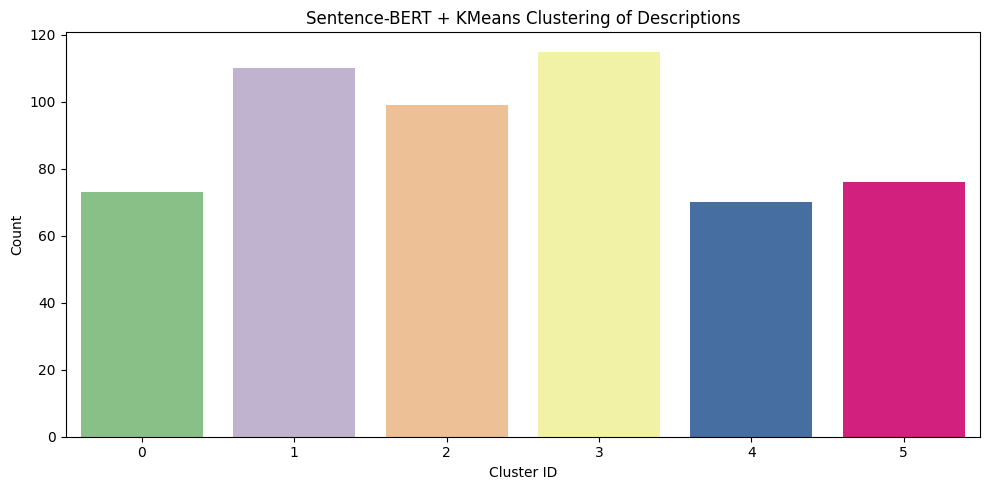


Cluster 0 Examples:
             strange circle of lights in night sky
saw a silent transparentblack triangular craft ...
                                       glowing orb

Cluster 1 Examples:
      suddenly see the object coming from the star
it was moving silently no sound nothing just a ...
bigger and bright than comet speedier than rock...

Cluster 2 Examples:
seen from the window of a flat on the fourth fl...
i was waiting for my father when i saw a disk l...
i went to get my dry cleaned bed sheets from to...

Cluster 3 Examples:
it looked like a drone i thought it was one emi...
i saw several ufo coming from down to up they f...
i was on a trip with my friends and we saw a fl...

Cluster 4 Examples:
circular object hovering on top of my village l...
unidentified flying object oversky in gurgaon i...
sophisticated aircraft like objects among cloud...

Cluster 5 Examples:
                     uap spotted over kerala india
i did not see craft i had a contact in my room ...
initial

In [ ]:
# Visualization
plt.figure(figsize=(10, 5))
sns.countplot(data=df, x='cluster', palette='Accent')
plt.title('Sentence-BERT + KMeans Clustering of Descriptions')
plt.xlabel('Cluster ID')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

# Show examples from each cluster
for i in range(6):
    print(f"\nCluster {i} Examples:")
    print(df[df['cluster'] == i]['cleaned_description'].head(3).to_string(index=False))


# More Analysis on the Clusters

### 1. 🔍 Top Words / Phrases per Cluster
Show what words dominate each cluster’s descriptions.


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

def get_top_words_per_cluster(df, text_col='cleaned_description', cluster_col='cluster', top_n=10):
    cluster_keywords = {}
    for cluster in sorted(df[cluster_col].unique()):
        texts = df[df[cluster_col] == cluster][text_col]
        vec = CountVectorizer(stop_words='english').fit(texts)
        bag = vec.transform(texts)
        word_freq = bag.sum(axis=0).A1
        vocab = vec.get_feature_names_out()
        top_words = sorted(zip(vocab, word_freq), key=lambda x: x[1], reverse=True)[:top_n]
        cluster_keywords[cluster] = top_words
    return cluster_keywords

top_words = get_top_words_per_cluster(df)
for cluster, words in top_words.items():
    print(f"\nCluster {cluster} top words:")
    print([word for word, _ in words])



Cluster 0 top words:
['lights', 'light', 'shape', 'white', 'triangle', 'shaped', 'like', 'object', 'bright', 'sky']

Cluster 1 top words:
['moving', 'sky', 'light', 'object', 'star', 'bright', 'like', 'saw', 'seen', 'east']

Cluster 2 top words:
['object', 'like', 'flying', 'moving', 'speed', 'shaped', 'saw', 'fast', 'red', 'shape']

Cluster 3 top words:
['saw', 'sky', 'ufo', 'object', 'light', 'lights', 'like', 'flying', 'night', 'seen']

Cluster 4 top words:
['india', 'sky', 'object', 'seen', 'light', 'lights', 'bright', 'like', 'moving', 'bangalore']

Cluster 5 top words:
['ufo', 'india', 'sighting', 'time', 'seen', 'night', 'saw', 'ufos', 'city', 'sighted']


### 2. 😱 Sentiment Comparison Across Clusters
Do some clusters show more fear? More amazement?


<ipython-input-30-7a63239828ab>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='cluster', y='vader_score', palette='coolwarm')


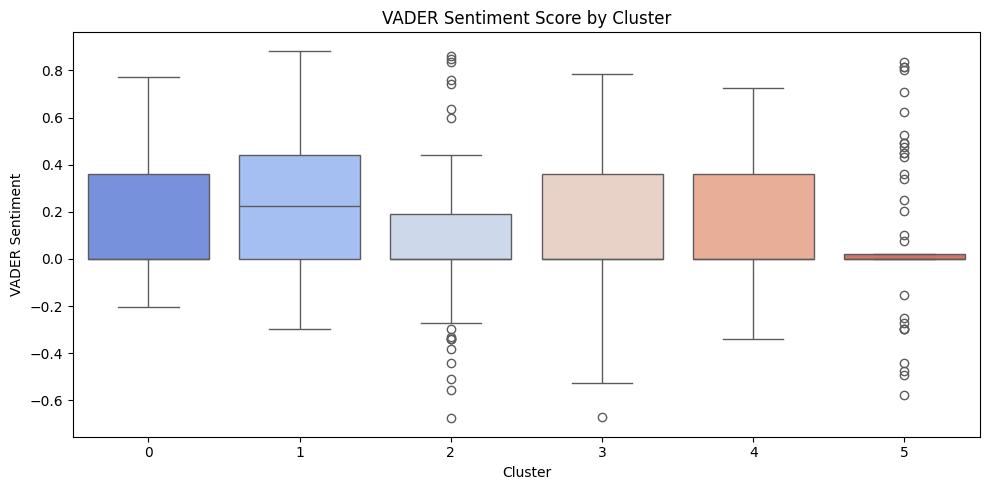

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
sns.boxplot(data=df, x='cluster', y='vader_score', palette='coolwarm')
plt.title('VADER Sentiment Score by Cluster')
plt.xlabel('Cluster')
plt.ylabel('VADER Sentiment')
plt.tight_layout()
plt.show()


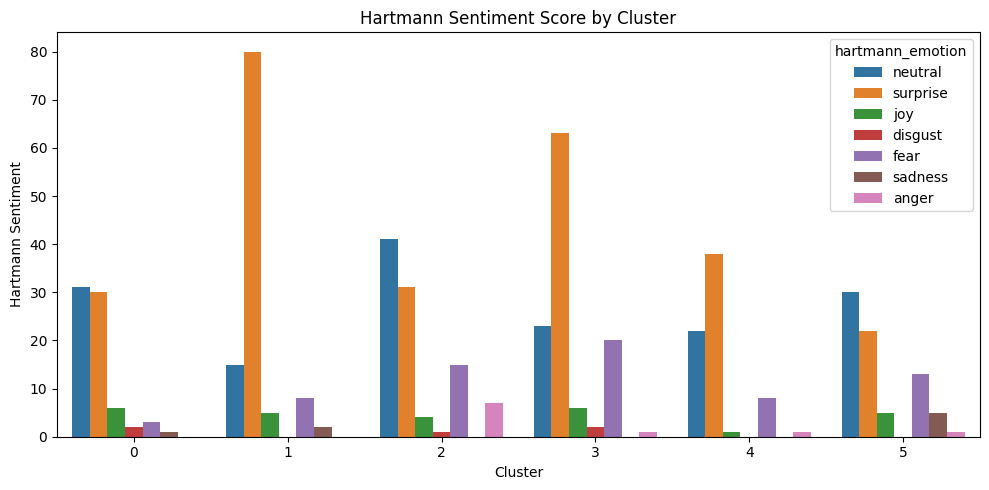

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
sns.countplot(data=df, x='cluster', hue='hartmann_emotion')
plt.title('Hartmann Sentiment Score by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Hartmann Sentiment')
plt.tight_layout()
plt.show()


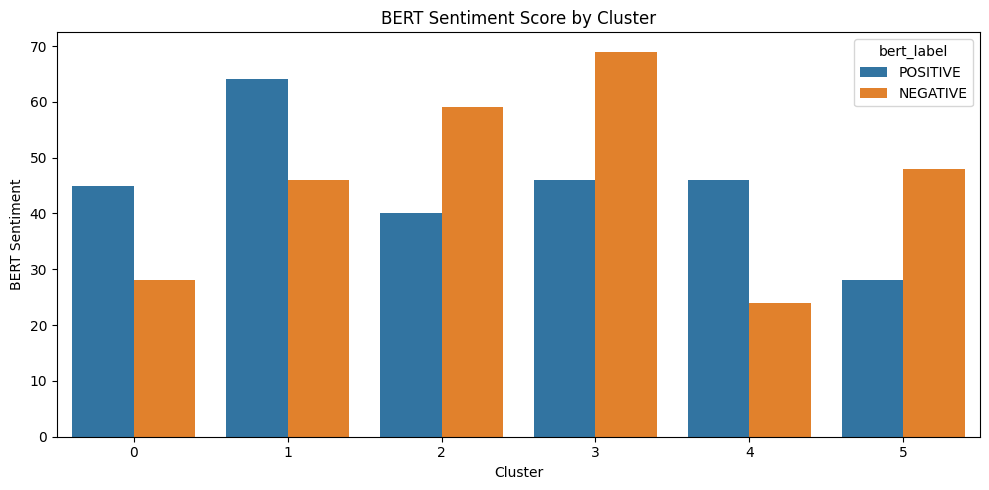

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
sns.countplot(data=df, x='cluster', hue='bert_label')
plt.title('BERT Sentiment Score by Cluster')
plt.xlabel('Cluster')
plt.ylabel('BERT Sentiment')
plt.tight_layout()
plt.show()


### 3. 🕒 Cluster by Time / Year
Do clusters relate to certain time periods?

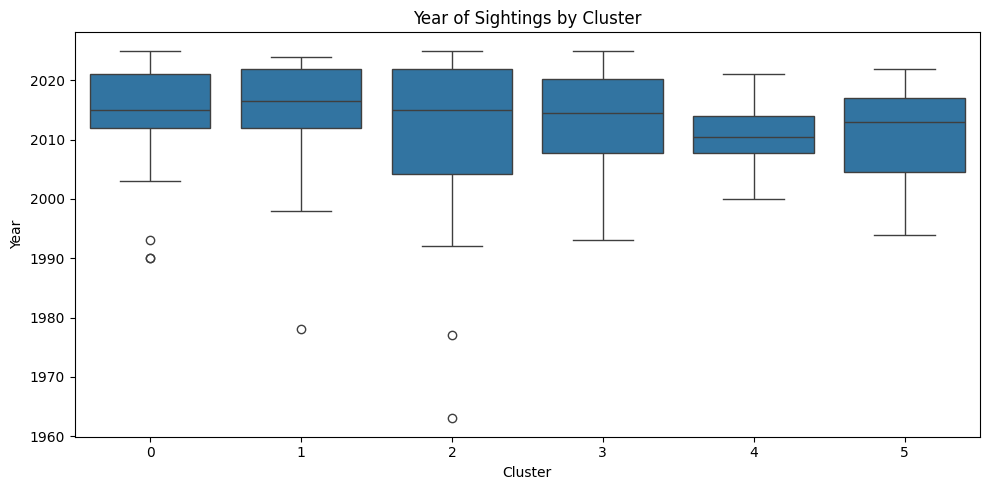

In [ ]:
df['year'] = pd.to_datetime(df['datetime'], errors='coerce').dt.year

plt.figure(figsize=(10, 5))
sns.boxplot(data=df, x='cluster', y='year')
plt.title('Year of Sightings by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Year')
plt.tight_layout()
plt.show()


### 4. 🛸 Cluster by UFO Shape
(If you have a shape column)

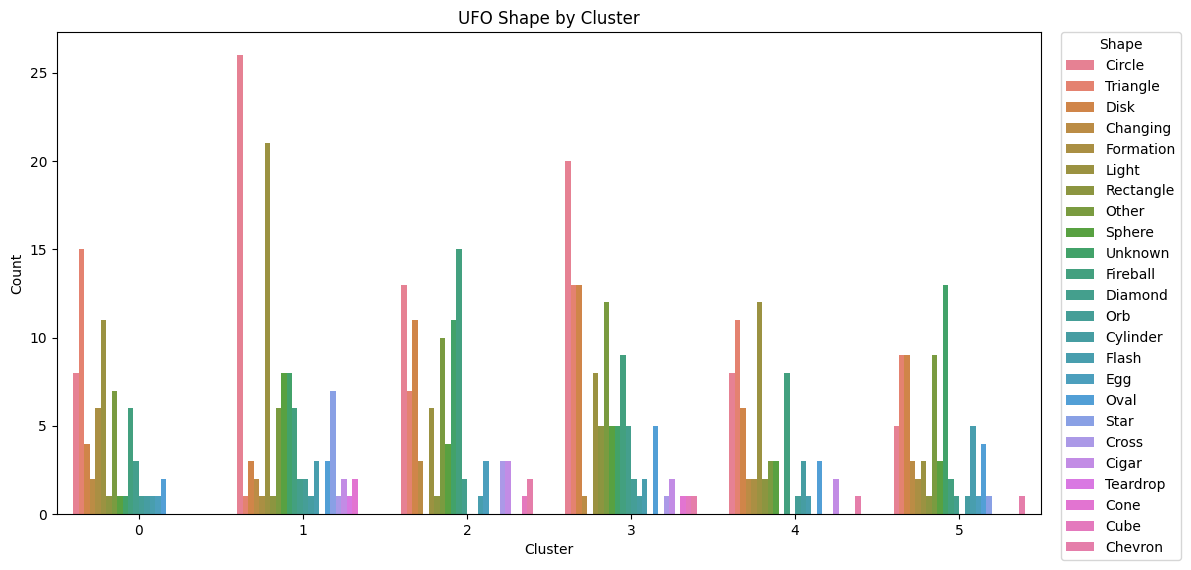

In [ ]:
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='cluster', hue='Shape')
plt.title('UFO Shape by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Count')

# Move legend to the right
plt.legend(title='Shape', bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.tight_layout()
plt.show()


### 5. 🌍 Cluster Geography
(If state or country columns are available)

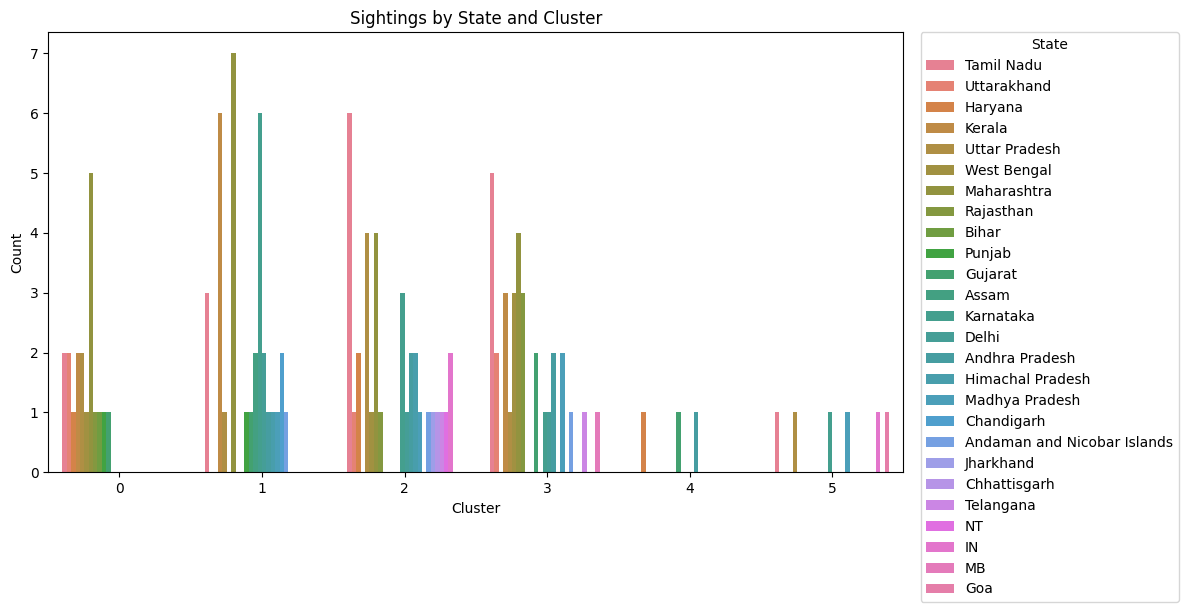

In [ ]:
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='cluster', hue='State')
plt.title('Sightings by State and Cluster')
plt.xlabel('Cluster')
plt.ylabel('Count')

# Move legend to the side
plt.legend(title='State', bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.tight_layout()
plt.show()


### 6. 🧠 Topic Modeling Within Clusters
Use LDA or BERTopic inside each cluster to find subthemes.

In [ ]:
from sklearn.decomposition import LatentDirichletAllocation

texts = df[df['cluster'] == 0]['cleaned_description']
cv = CountVectorizer(stop_words='english', max_features=500)
X = cv.fit_transform(texts)

lda = LatentDirichletAllocation(n_components=3)
lda.fit(X)

for idx, topic in enumerate(lda.components_):
    print(f"Topic #{idx + 1}:")
    print([cv.get_feature_names_out()[i] for i in topic.argsort()[-10:]])


Topic #1:
['triangle', 'object', 'formation', 'like', 'flashing', 'shape', 'bright', 'white', 'light', 'lights']
Topic #2:
['colour', 'object', 'dim', 'sky', 'shaped', 'moving', 'light', 'shape', 'triangle', 'lights']
Topic #3:
['sky', 'line', 'object', 'objects', 'white', 'blinking', 'shaped', 'light', 'lights', 'red']


# Tabulation

Step 1

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

def get_top_words_per_cluster(df, text_col='cleaned_description', cluster_col='cluster', top_n=10):
    cluster_keywords = {}
    for cluster in sorted(df[cluster_col].unique()):
        texts = df[df[cluster_col] == cluster][text_col]
        vec = CountVectorizer(stop_words='english').fit(texts)
        bag = vec.transform(texts)
        word_freq = bag.sum(axis=0).A1
        vocab = vec.get_feature_names_out()
        top_words = sorted(zip(vocab, word_freq), key=lambda x: x[1], reverse=True)[:top_n]
        cluster_keywords[cluster] = top_words
    return cluster_keywords

# Apply it
top_words = get_top_words_per_cluster(df)

# Print results
for cluster, words in top_words.items():
    print(f"\n🔹 Cluster {cluster} — Top Words:")
    print(", ".join([word for word, _ in words]))



🔹 Cluster 0 — Top Words:
lights, light, shape, white, triangle, shaped, like, object, bright, sky

🔹 Cluster 1 — Top Words:
moving, sky, light, object, star, bright, like, saw, seen, east

🔹 Cluster 2 — Top Words:
object, like, flying, moving, speed, shaped, saw, fast, red, shape

🔹 Cluster 3 — Top Words:
saw, sky, ufo, object, light, lights, like, flying, night, seen

🔹 Cluster 4 — Top Words:
india, sky, object, seen, light, lights, bright, like, moving, bangalore

🔹 Cluster 5 — Top Words:
ufo, india, sighting, time, seen, night, saw, ufos, city, sighted


✅ Step 2 includes:
📈 Plot: Boxplot of Hartmann sentiment per cluster

📉 Optionally: Barplot of average sentiment per cluster (for tabular reporting)

📄 Value Summary: A dictionary or DataFrame of cluster-wise average sentiment — so we can include it in the table

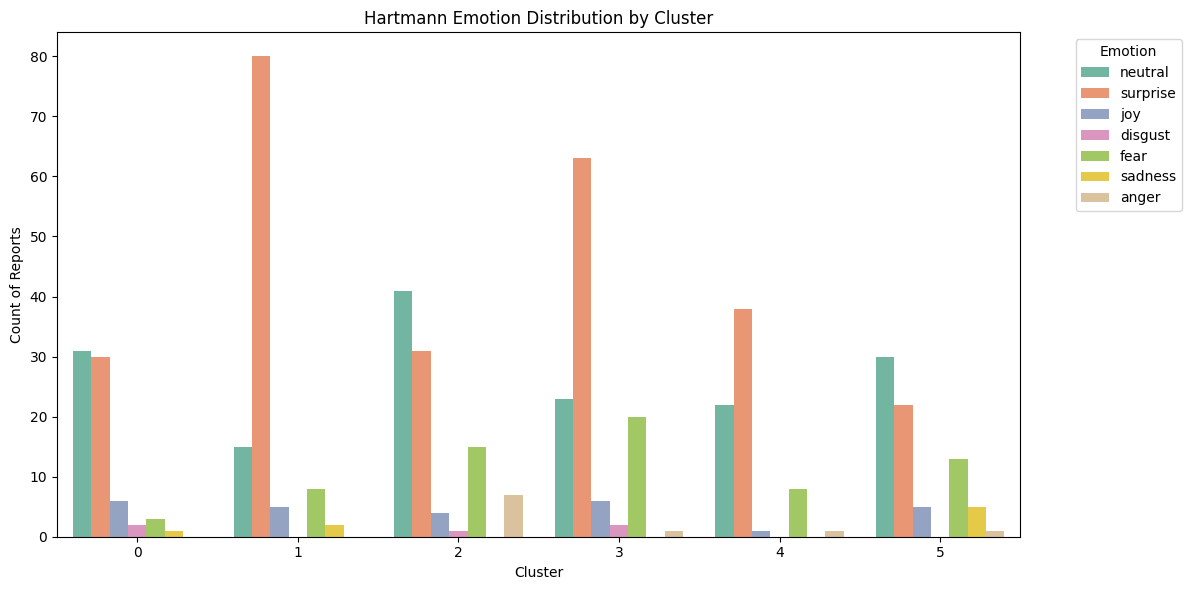

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='cluster', hue='hartmann_emotion', palette='Set2')
plt.title('Hartmann Emotion Distribution by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Count of Reports')
plt.legend(title='Emotion', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [ ]:
# Most common emotion per cluster
dominant_emotion = (
    df.groupby('cluster')['hartmann_emotion']
    .agg(lambda x: x.value_counts().index[0])
)

print("📄 Dominant Hartmann Emotion per Cluster:")
print(dominant_emotion)


📄 Dominant Hartmann Emotion per Cluster:
cluster
0     neutral
1    surprise
2     neutral
3    surprise
4    surprise
5     neutral
Name: hartmann_emotion, dtype: object


✅ Step 3: Code to Analyze Year Ranges per Cluster

In [ ]:
# Extract year from the Occurred column
df['datetime'] = pd.to_datetime(df['Occurred'], errors='coerce')
df['year'] = df['datetime'].dt.year

# 📄 Summary: Min–Max year per cluster
year_range = df.groupby('cluster')['year'].agg(['min', 'max', lambda x: x.mode().iloc[0]])
year_range.columns = ['year_min', 'year_max', 'most_common_year']
print("📄 Year Range and Most Common Year per Cluster:")
print(year_range)


📄 Year Range and Most Common Year per Cluster:
         year_min  year_max  most_common_year
cluster                                      
0          1990.0    2025.0            2015.0
1          1978.0    2024.0            2024.0
2          1963.0    2025.0            2015.0
3          1993.0    2025.0            2023.0
4          2000.0    2021.0            2008.0
5          1994.0    2022.0            2012.0


<ipython-input-43-d9006a3fb05a>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='cluster', y='year', palette='crest')


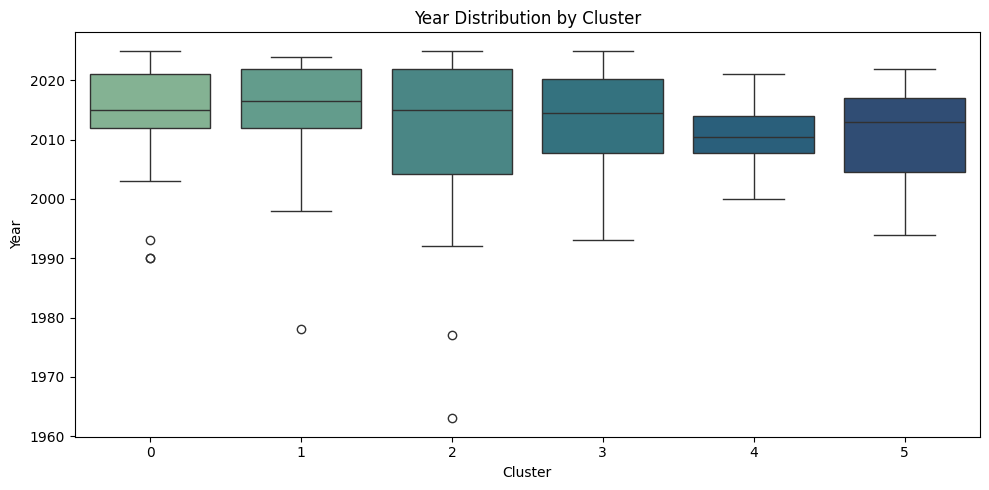

In [ ]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=df, x='cluster', y='year', palette='crest')
plt.title('Year Distribution by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Year')
plt.tight_layout()
plt.show()


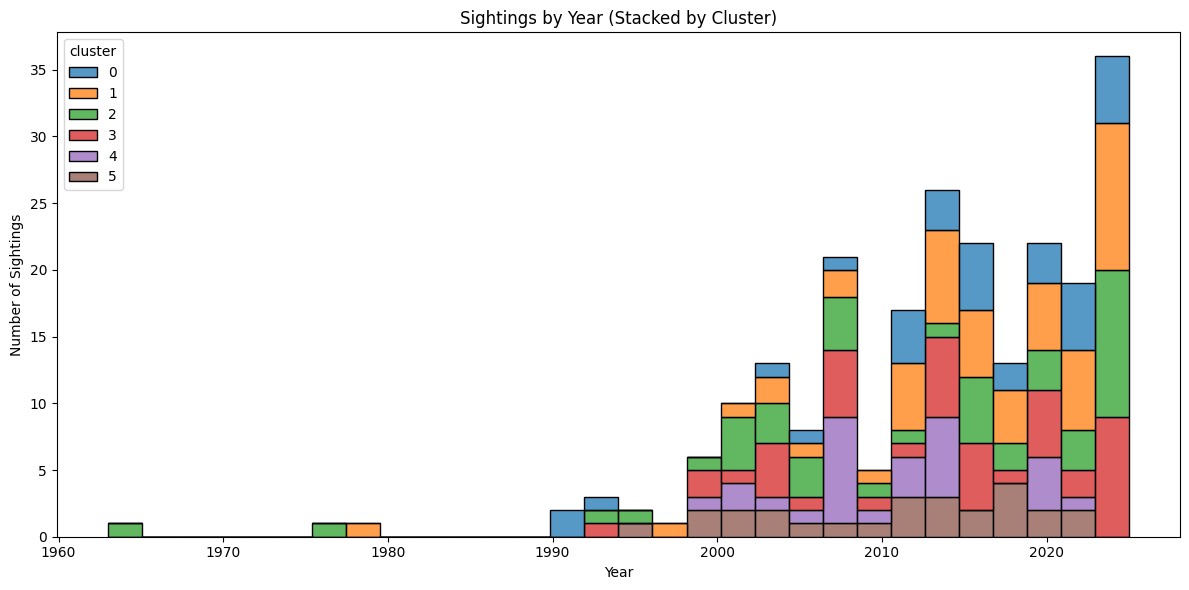

In [ ]:
plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='year', hue='cluster', multiple='stack', palette='tab10', bins=30)
plt.title('Sightings by Year (Stacked by Cluster)')
plt.xlabel('Year')
plt.ylabel('Number of Sightings')
plt.tight_layout()
plt.show()


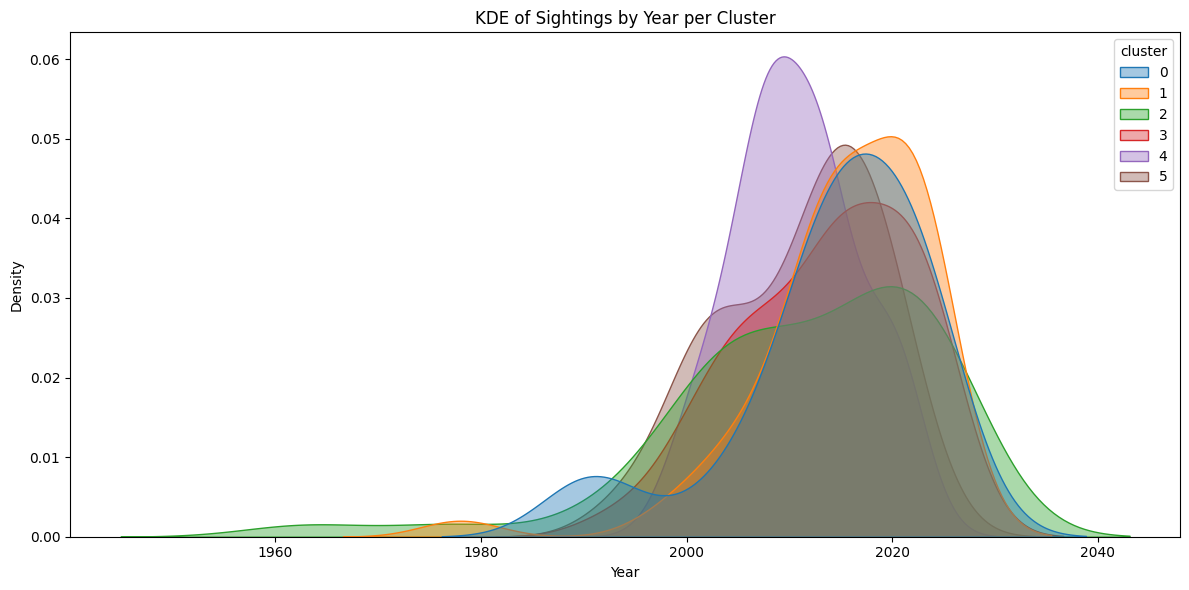

In [ ]:
plt.figure(figsize=(12, 6))
sns.kdeplot(data=df, x='year', hue='cluster', common_norm=False, fill=True, palette='tab10', alpha=0.4)
plt.title('KDE of Sightings by Year per Cluster')
plt.xlabel('Year')
plt.ylabel('Density')
plt.tight_layout()
plt.show()


✅ Step 4: Most Common Shape per Cluster

In [ ]:
# Make sure shape column exists and is clean
df['Shape'] = df['Shape'].fillna('Unknown').str.lower().str.strip()

# 📄 Summary: Most common shape per cluster
top_shapes = (
    df.groupby('cluster')['Shape']
    .agg(lambda x: x.value_counts().index[0])
)

print("📄 Most Common UFO Shape per Cluster:")
print(top_shapes)


📄 Most Common UFO Shape per Cluster:
cluster
0    triangle
1      circle
2    fireball
3      circle
4       light
5     unknown
Name: Shape, dtype: object


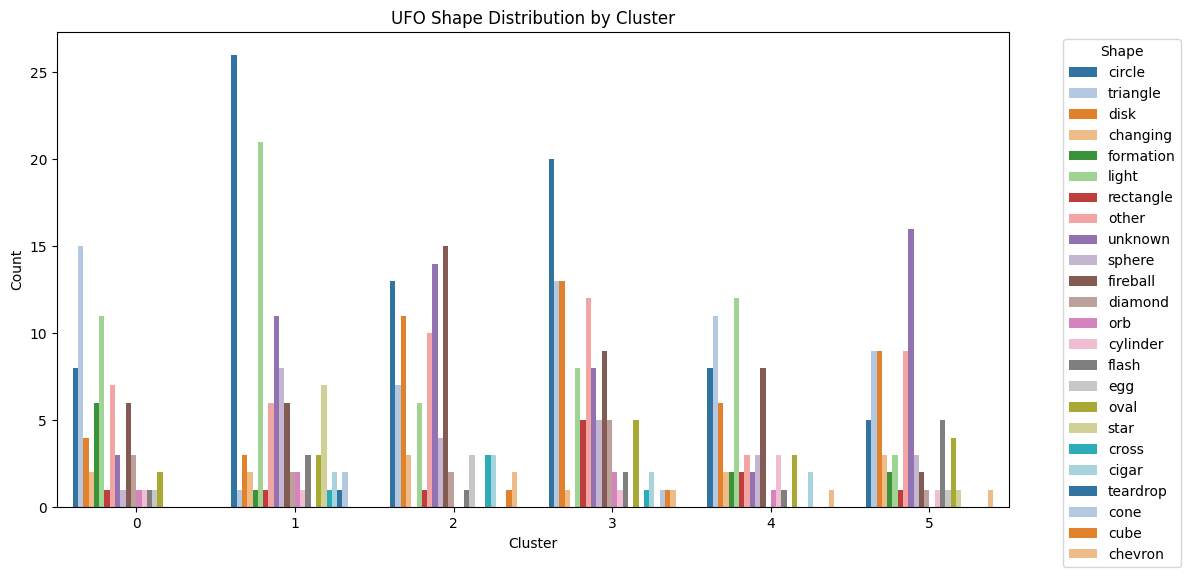

In [ ]:
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='cluster', hue='Shape', palette='tab20', order=sorted(df['cluster'].unique()))
plt.title('UFO Shape Distribution by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.legend(title='Shape', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


Awesome — let’s build the final Cluster Summary Table 🧠📋

We’ll combine:

🆔 Cluster ID

📝 Top 5 Words

💬 Dominant Emotion (hartmann_emotion)

📅 Most Common Year

🛸 Most Common Shape



In [ ]:
# 1. Top words per cluster (from earlier step)
from sklearn.feature_extraction.text import CountVectorizer

def get_top_words(df, cluster_col='cluster', text_col='cleaned_description', top_n=5):
    top_words_dict = {}
    for cluster in sorted(df[cluster_col].unique()):
        texts = df[df[cluster_col] == cluster][text_col]
        vec = CountVectorizer(stop_words='english').fit(texts)
        bag = vec.transform(texts)
        freqs = bag.sum(axis=0).A1
        vocab = vec.get_feature_names_out()
        words = sorted(zip(vocab, freqs), key=lambda x: x[1], reverse=True)[:top_n]
        top_words_dict[cluster] = ", ".join([w for w, _ in words])
    return top_words_dict

# Extract cluster-level values
cluster_ids = sorted(df['cluster'].unique())
top_words = get_top_words(df)
dominant_emotions = df.groupby('cluster')['hartmann_emotion'].agg(lambda x: x.value_counts().index[0])
most_common_year = df.groupby('cluster')['year'].agg(lambda x: x.mode().iloc[0])
top_shapes = df.groupby('cluster')['Shape'].agg(lambda x: x.value_counts().index[0])

# Combine into summary DataFrame
summary_df = pd.DataFrame({
    'Cluster': cluster_ids,
    'Top Words': [top_words[c] for c in cluster_ids],
    'Dominant Emotion': dominant_emotions.values,
    'Most Common Year': most_common_year.values,
    'Most Common Shape': top_shapes.values
})

# Display and optionally save
print("📋 Cluster Summary Table:\n")
display(summary_df)

# Optional: Save to CSV
summary_df.to_csv("cluster_summary_table.csv", index=False)


📋 Cluster Summary Table:



,Cluster,Top Words,Dominant Emotion,Most Common Year,Most Common Shape
0,0,"lights, light, shape, white, triangle",neutral,2015.0,triangle
1,1,"moving, sky, light, object, star",surprise,2024.0,circle
2,2,"object, like, flying, moving, speed",neutral,2015.0,fireball
3,3,"saw, sky, ufo, object, light",surprise,2023.0,circle
4,4,"india, sky, object, seen, light",surprise,2008.0,light
5,5,"ufo, india, sighting, time, seen",neutral,2012.0,unknown
